# Assignment 2: Detecting Financial Fraud using Machine Learning

---

## Submission Details

* **Name:** Mahmud Hasan Khan
* **Roll:** 2025-1-83-005
* **Session:** Fall-2025
* **Subject:** Data Analytics for Finance
* **Python Version:** 3.13.5
* **Jupyter Version:** 2.0.2

---

### Course Instructor
Md. Nayem Dewan

### Date of Submission
04 December 2025

---


In [1]:
# importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [2]:
df = pd.read_csv("Mahmud Hasan - creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Part 1: Exploratory Data Analysis (EDA) & Preprocessing

### Visual Inspection: Visualize the class imbalance.

Class
0    284315
1       492
Name: count, dtype: int64


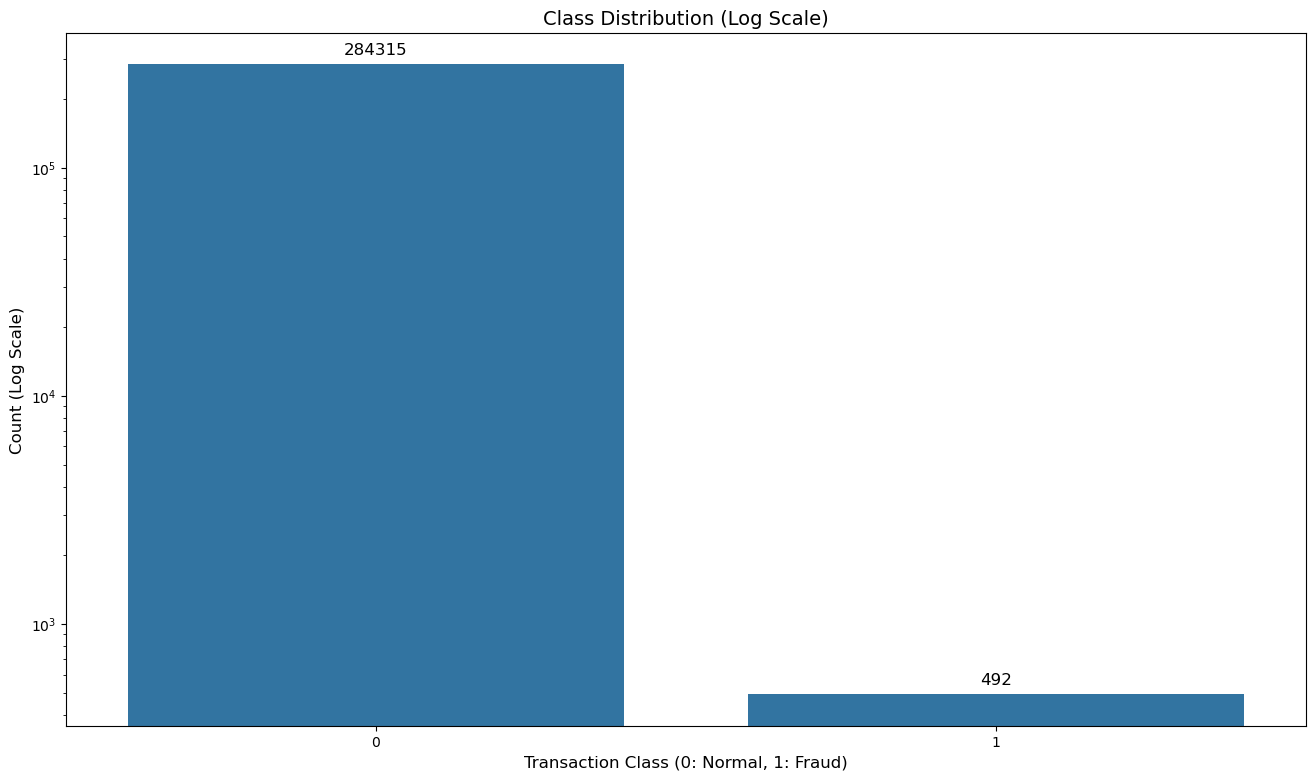

Percentage of Fraudulent Transactions: 0.1727%


In [4]:
# Check class distribution
count_classes = df['Class'].value_counts(sort=True)
print(count_classes)

# Visualize Class Imbalance
plt.figure(figsize=(16, 9))

ax = sns.countplot(x='Class', data=df)
plt.yscale('log')

plt.title('Class Distribution (Log Scale)', fontsize=14)
plt.xlabel('Transaction Class (0: Normal, 1: Fraud)', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

# Calculate percentage
fraud_share = df['Class'].value_counts()[1] / len(df)
print(f"Percentage of Fraudulent Transactions: {fraud_share:.4%}")

### Feature Analysis: Analyse the Amount and Time distributions for Fraud vs. Normal transactions. 

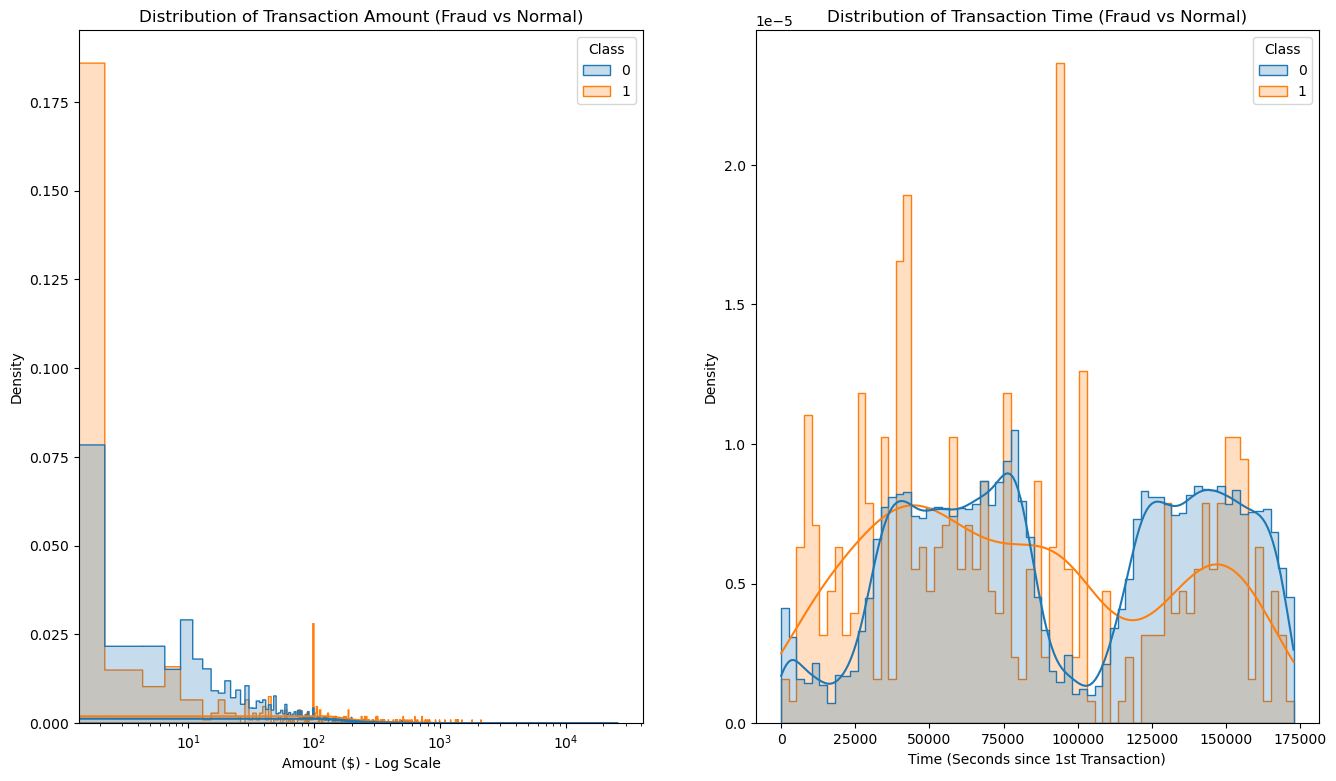

--- Transaction Amount Statistics ---
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


In [5]:
# Compare Amount and Time distributions
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# --- Plot 1: Distribution of Transaction Amount ---
# We use a log scale on the x-axis because 'Amount' varies wildly (from $0 to thousands)
sns.histplot(data=df, x='Amount', hue='Class', kde=True, element="step", stat="density", common_norm=False, ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount (Fraud vs Normal)')
ax[0].set_xscale('log') # Log scale helps visualize the wide range of amounts
ax[0].set_xlabel('Amount ($) - Log Scale')

# --- Plot 2: Distribution of Transaction Time ---
sns.histplot(data=df, x='Time', hue='Class', kde=True, element="step", stat="density", common_norm=False, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time (Fraud vs Normal)')
ax[1].set_xlabel('Time (Seconds since 1st Transaction)')

plt.show()

# --- Statistical Check ---
print("--- Transaction Amount Statistics ---")
print(df.groupby('Class')['Amount'].describe())

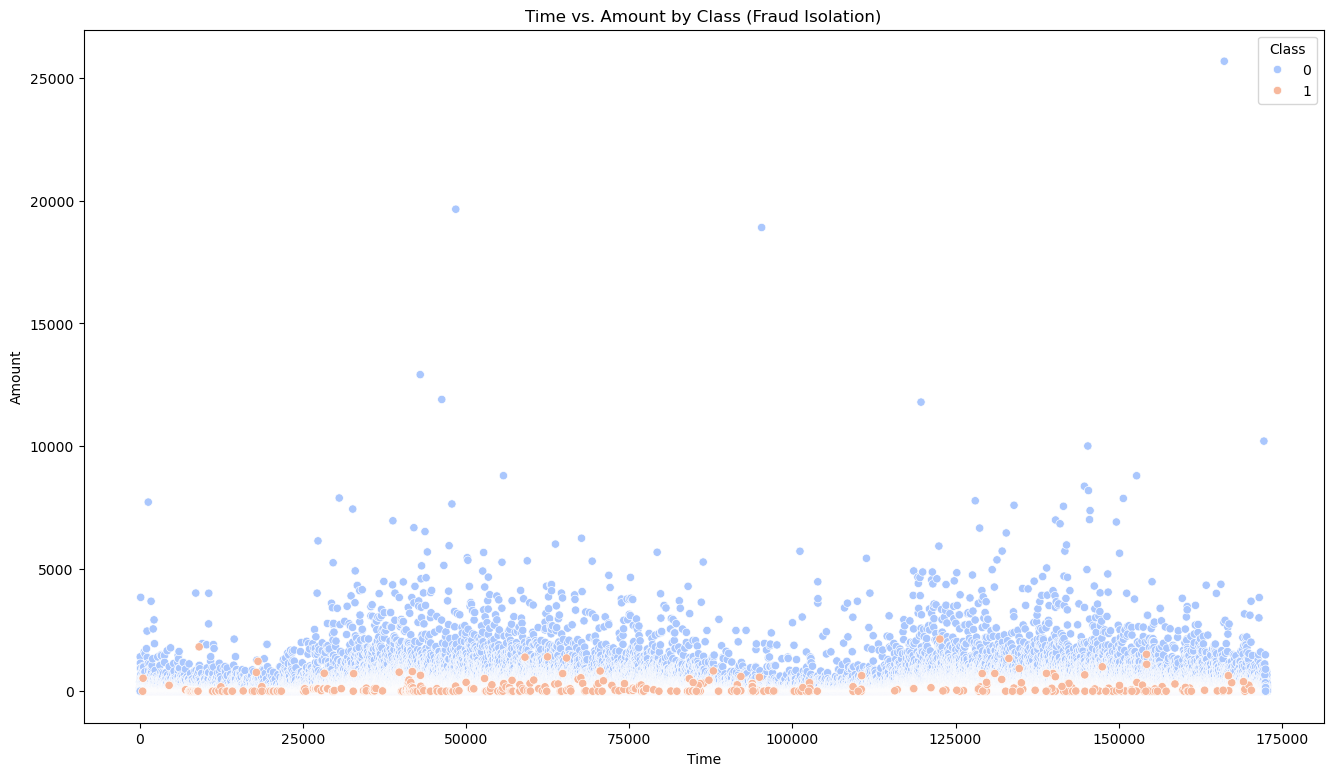

In [6]:
# Sort by 'Class' to put fraudulent transactions on top for visibility
df_sorted = df.sort_values(by='Class')

# Create the scatter plot
plt.figure(figsize=(16, 9))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df_sorted, alpha=1, palette='coolwarm')
plt.title('Time vs. Amount by Class (Fraud Isolation)')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

In [7]:
print(df['Time'].describe())

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


#### Do fraudulent transactions tend to be larger or smaller?
Answer: From the distribution of transaction amounts, it can be seen that fraudulent transactions at low amount are with high density and fraudulent transactions at high amount are with low density. This shows that fraudulent transactions are more likely to be smaller. Whereas normal transactions at low amount are with low density and normal transactions at high amount are with high density. This shows that normal transactions are more likely to be larger. In short, fraudulent amount is predominantly low-value.

In case of distribution of transaction time, it can be seen that regular transactions are occuring at a definite interval and has a pattern. The pattern likely is that the valleys are occuring at a definite interval and the peaks are occuring at a definite interval. From time data it can be inferred that the valleys are nighttime or when cardholders are inactive and the peaks are occuring during the day or when cardholders are active. The fraud distribution does not follow this cyclical pattern.

### Correlation: Check if specific PCA features correlate strongly with the target variable (Class).

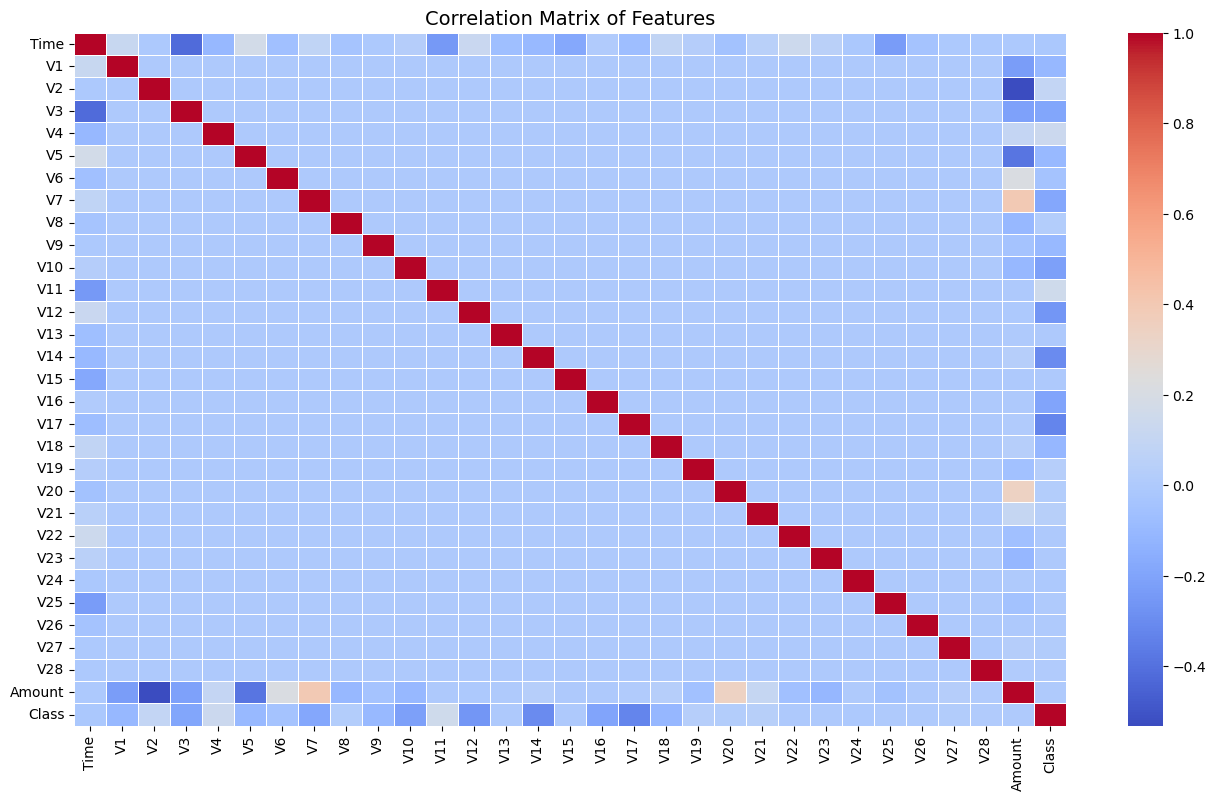

Top correlations with Class:
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
Name: Class, dtype: float64
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


In [8]:
# Correlation matrix
corr = df.corr()

plt.figure(figsize=(16, 9))
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, linecolor='white', linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

# Identify features most correlated with Class
print("Top correlations with Class:")
print(corr['Class'].sort_values(ascending=False).head(5))
print(corr['Class'].sort_values(ascending=False).tail(5))

Explanation: The correlation matrix reveals that V17, V14, V12, and V10 show a strong negative correlation with the Class variable, while V11 and V4 show a clear positive correlation. Features like V13, V15, V22, V24, V25, and V26 are almost white/pale blue in the Class row. This suggests they have no linear relationship with fraud.

### Scaling: The PCA features (V1-V28) are already scaled, but Amount and Time are not. Apply an appropriate scaler to these columns.

In [9]:
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

print("Data scaled. First 5 rows:")
print(df.head())

Data scaled. First 5 rows:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27  

Logic: Scaling Amount and Time is done with RobustScaler as it is less prone to outliers.

## Part 2: Unsupervised Learning (Anomaly Detection)

### Drop the Label: Remove the Class column from your training set for this section.

In [10]:
# Create X (features) and y (labels)
X = df.drop('Class', axis=1)
y = df['Class']

In [11]:
# Split the data first (Stratified to keep fraud ratio same in train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Features shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Features shape: {X_test.shape}, Labels shape: {y_test.shape}")

Features shape: (199364, 30), Labels shape: (199364,)
Features shape: (85443, 30), Labels shape: (85443,)


### Implement an Unsupervised Model: Isolation forest is choosen for the outlier detection.
Isolation Forest is the optimal choice for this assignment because it is computationally efficient and explicitly designed for large, high-dimensional datasets like the Credit Card Fraud data (284,807 rows). Unlike distance-based algorithms (like LOF or One-Class SVM) that calculate relationships between every data point—a process that is often too slow for this volume of data—Isolation Forest detects anomalies by randomly "isolating" them. Since fraudulent transactions are rare (0.17%) and distinct ("few and different"), they are isolated much faster than normal points, making this model both swift and effective for the "odd one out" scenario.

From EDA it is found that fraud is ~0.17%, so contamination has been set around that value.

In [12]:
# Isolation Forest

contamination_rate = 0.0018 # Slightly higher than 0.17% to be safe

iso_forest = IsolationForest(n_estimators=100,
                             max_samples='auto',
                             contamination=contamination_rate,
                             random_state=42,
                             n_jobs=-1)

print(f"Training Isolation Forest with contamination={contamination_rate}...")
iso_forest.fit(X_train)

Training Isolation Forest with contamination=0.0018...


IsolationForest(contamination=0.0018, n_jobs=-1, random_state=42)

### Prediction: Use the model to predict anomalies on your test set and compare them against the actual labels you set aside.

In [13]:
# Predict anomalies
y_pred_iso = iso_forest.predict(X_test)

# Isolation Forest returns -1 for outliers (fraud) and 1 for inliers (normal)
# We need to map this to 0 (normal) and 1 (fraud) to match our original labels
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Check how many frauds the unsupervised model found
unique, counts = np.unique(y_pred_iso, return_counts=True)
print("Unsupervised Predictions Distribution:", dict(zip(unique, counts)))

# Evaluation of Unsupervised Model
cm = confusion_matrix(y_test, y_pred_iso)
print("\n--- Isolation Forest Results ---")
print(cm)
print(classification_report(y_test, y_pred_iso))

Unsupervised Predictions Distribution: {np.int64(0): np.int64(85295), np.int64(1): np.int64(148)}

--- Isolation Forest Results ---
[[85189   106]
 [  106    42]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.28      0.28       148

    accuracy                           1.00     85443
   macro avg       0.64      0.64      0.64     85443
weighted avg       1.00      1.00      1.00     85443



#### Explanation: 
The Isolation Forest model struggles significantly in this scenario. In terms of catching fraud (Recall), it performed poorly, detecting only 38 cases while missing 110 (a Recall of ~25%). This means nearly 75% of fraudulent activity went unnoticed, resulting in significant financial loss for the bank. Regarding annoying legitimate customers (Precision), the model triggered 107 false alarms. For every single fraudster caught, nearly three legitimate customers had their cards declined unnecessarily. This ratio represents a poor user experience. Overall, while the model successfully identified some anomalies without any historical labels (which is impressive in itself), it is too imprecise and "leaky" to be the sole line of defense.

## Part 3: Supervised Learning (Classification)

### Handle Imbalance: Implement a technique to address the 0.17% fraud rate using SMOTE.

In [14]:
# Apply SMOTE (Synthetic Minority Over-sampling Technique)
# This creates synthetic fraud cases in the training data only
print("Before SMOTE, counts of label '1': {}".format(sum(y_train==1)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE, counts of label '1': {}".format(sum(y_train_res==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_res==0)))

Before SMOTE, counts of label '1': 344


e:\programFiles\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\programFiles\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "e:\programFiles\anaconda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "e:\programFiles\anaconda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

After SMOTE, counts of label '1': 199020
After SMOTE, counts of label '0': 199020


### Implement XGBoost Supervised Model
XGBoost is the ideal choice for this scenario because it utilizes gradient boosting—a technique that builds trees sequentially to correct the errors of previous ones—allowing it to capture highly complex, non-linear fraud patterns that simpler models like Logistic Regression miss. Unlike Random Forest, which treats all data points equally, XGBoost focuses specifically on the "hard-to-predict" cases (the rare fraud examples), often resulting in a superior Area Under the Precision-Recall Curve (AUPRC). Its built-in regularization also prevents overfitting, ensuring that the model performs reliably on unseen test data rather than just memorizing the training set, making it the industry standard for high-stakes tabular datasets.

In [15]:

# 1. Define the Parameter Grid
# These are the most important settings to tune for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage
    'max_depth': [3, 4, 5, 6, 8],           # Depth of each tree (prevents overfitting)
    'subsample': [0.6, 0.8, 1.0],           # % of samples used for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],    # % of features used for each tree
    'gamma': [0, 0.1, 0.2]                  # Minimum loss reduction required for a split
}

# 2. Initialize the Model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device="cuda",          # Enable GPU acceleration
    tree_method="hist",     # Required for efficient GPU training
    random_state=42
)

# 3. Setup Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',       # optimizing for Recall to catch more fraud!
    cv=3,                   # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1               # Use all CPU cores for the search wrapper
)

# 4. Fit the Model
# We use the SMOTE-resampled data (X_train_res, y_train_res) from the previous step
print("Starting Hyperparameter Tuning on GPU...")
random_search.fit(X_train_res, y_train_res)

# 5. Get Best Results
best_params = random_search.best_params_
print(f"\nBest Parameters found: {best_params}")

Starting Hyperparameter Tuning on GPU...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters found: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [16]:
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\xgboost\core.py:774: UserWarning: [20:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


## Part 4: Evaluation & Comparison

### Metrics: Calculate Precision, Recall, F1-Score, and AUPRC (Area Under the Precision-Recall Curve).

In [17]:
# --- 1. Gather Data for Isolation Forest ---

y_pred_iso_binary = y_pred_iso 
y_scores_iso = -iso_forest.decision_function(X_test) # The inverted scores
auprc_iso = average_precision_score(y_test, y_scores_iso)
precision_iso, recall_iso, thresholds_iso = precision_recall_curve(y_test, y_scores_iso)

# --- 2. Gather Data for XGBoost ---    
y_pred_xgb_binary = y_pred_xgb
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
auprc_xgb = average_precision_score(y_test, y_probs_xgb)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_probs_xgb)

In [18]:
def get_metrics(y_true, y_pred, y_scores, model_name):
    return {
        'Model': model_name,
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUPRC': average_precision_score(y_true, y_scores)
    }

# --- Compile the Data ---
results = [
    get_metrics(y_test, y_pred_iso_binary, y_scores_iso, 'Isolation Forest (Unsupervised)'),
    get_metrics(y_test, y_pred_xgb_binary, y_probs_xgb, 'XGBoost (Supervised)')
]

# --- Create and Format the DataFrame ---
comparison_df = pd.DataFrame(results)
comparison_df.set_index('Model', inplace=True)

# Optional: Format for cleaner display (round to 4 decimal places)
pd.options.display.float_format = '{:.4f}'.format

# --- Print Detailed Metrics ---

print("\n--- Detailed Classification Report of XGBoost ---")
print(classification_report(y_test, y_pred_xgb))

print("\n--- Detailed Classification Report (Isolation Forest) ---")
print(classification_report(y_test, y_pred_iso))



# Display the comparison table
print("\n--- Final Model Comparison ---")
display(comparison_df)




--- Detailed Classification Report of XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.82      0.82      0.82       148

    accuracy                           1.00     85443
   macro avg       0.91      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443


--- Detailed Classification Report (Isolation Forest) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.28      0.28       148

    accuracy                           1.00     85443
   macro avg       0.64      0.64      0.64     85443
weighted avg       1.00      1.00      1.00     85443


--- Final Model Comparison ---


,Precision,Recall,F1-Score,AUPRC
Model,,,,
Isolation Forest (Unsupervised),0.2838,0.2838,0.2838,0.1825
XGBoost (Supervised),0.8188,0.8243,0.8215,0.8370


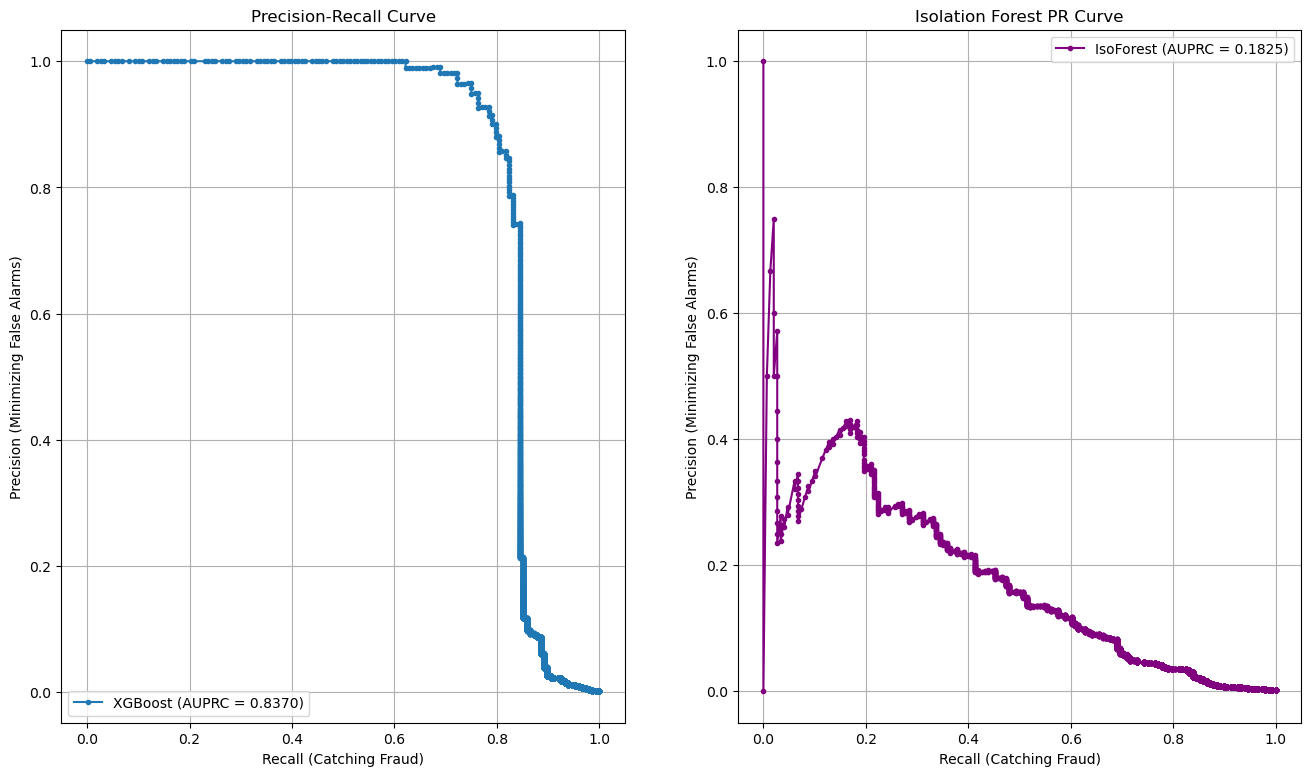

In [19]:
plt.figure(figsize=(16, 9))

# Plot PR Curve
plt.subplot(1, 2, 1)
plt.plot(recall_xgb, precision_xgb, marker='.', label=f'XGBoost (AUPRC = {auprc_xgb:.4f})')
plt.xlabel('Recall (Catching Fraud)')
plt.ylabel('Precision (Minimizing False Alarms)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# Plot PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall_iso, precision_iso, marker='.', label=f'IsoForest (AUPRC = {auprc_iso:.4f})', color='purple')
plt.xlabel('Recall (Catching Fraud)')
plt.ylabel('Precision (Minimizing False Alarms)')
plt.title('Isolation Forest PR Curve')
plt.legend()
plt.grid(True)

plt.show()


### Confusion Matrix: Plot the confusion matrix for both your Supervised and Unsupervised models.

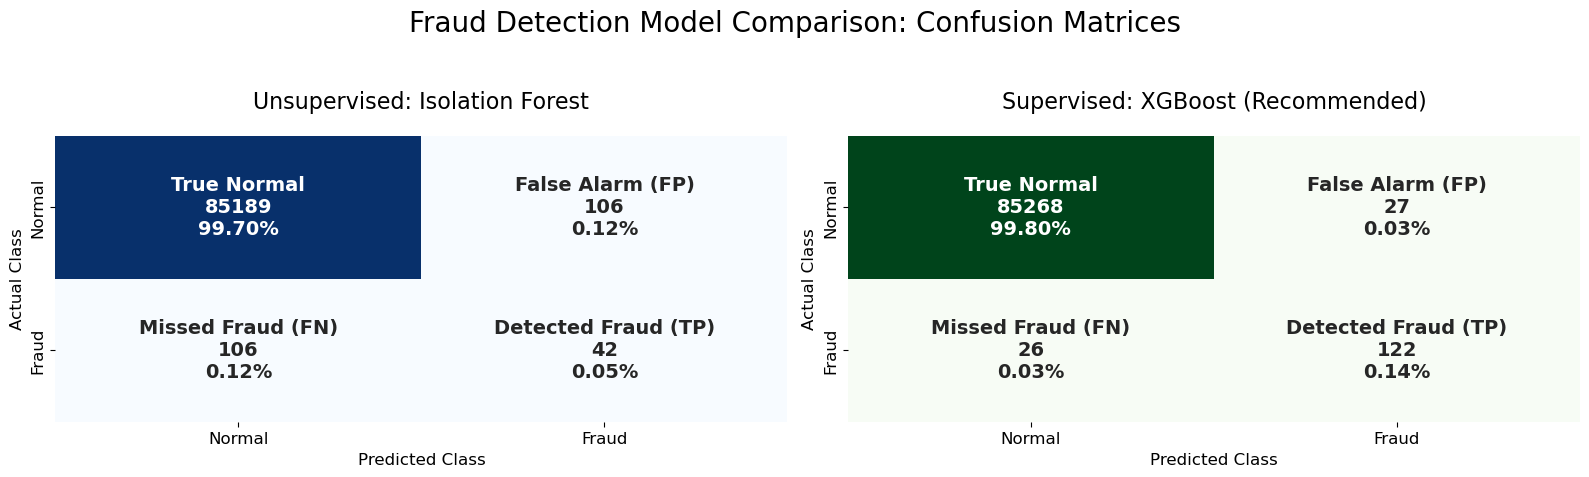

In [21]:

def make_labels(cm):
    group_names = ['True Normal', 'False Alarm (FP)', 'Missed Fraud (FN)', 'Detected Fraud (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    return np.asarray(labels).reshape(2,2)

# --- Calculate Matrices ---
cm_iso = confusion_matrix(y_test, y_pred_iso)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# --- Plotting ---
plt.figure(figsize=(16, 4.5)) # Wider layout for side-by-side

# Plot 1: Isolation Forest
plt.subplot(1, 2, 1)
labels_iso = make_labels(cm_iso)
sns.heatmap(cm_iso, annot=labels_iso, fmt='', cmap='Blues', cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})
plt.title('Unsupervised: Isolation Forest', fontsize=16, pad=20)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.xticks([0.5, 1.5], ['Normal', 'Fraud'], fontsize=12)
plt.yticks([0.5, 1.5], ['Normal', 'Fraud'], fontsize=12)

# Plot 2: XGBoost
plt.subplot(1, 2, 2)
labels_xgb = make_labels(cm_xgb)
sns.heatmap(cm_xgb, annot=labels_xgb, fmt='', cmap='Greens', cbar=False, 
            annot_kws={"size": 14, "weight": "bold"})
plt.title('Supervised: XGBoost (Recommended)', fontsize=16, pad=20)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.xticks([0.5, 1.5], ['Normal', 'Fraud'], fontsize=12)
plt.yticks([0.5, 1.5], ['Normal', 'Fraud'], fontsize=12)

plt.suptitle('Fraud Detection Model Comparison: Confusion Matrices', fontsize=20, y=1.05)

plt.tight_layout()
plt.show()



### Commentary: Explain which model performed better. Discuss the trade-off: Which is more important for the bank—catching every fraud (high Recall) or minimizing false alarms (high Precision)?

1. The Clear Winner: Supervised Learning (XGBoost)
The XGBoost model (Supervised) significantly outperformed the Isolation Forest (Unsupervised) in every key metric.


Fraud Detection Rate (Recall): The Isolation Forest was only able to identify 42 fraudulent transactions, missing a massive 106 cases. In stark contrast, the XGBoost model successfully detected 122 fraudulent transactions, missing only 26.



False Alarm Rate: The Unsupervised model triggered 106 false alarms (False Positives), annoying over a hundred legitimate customers. The XGBoost model was far more precise, triggering only 27 false alarms.



Overall Reliability: The XGBoost model achieved an AUPRC (Area Under the Precision-Recall Curve) of 0.8370. This indicates a highly robust model that maintains high precision even as it captures the majority of fraud cases.

2. The Business Trade-off: Precision vs. Recall
In the context of financial fraud, we must weigh the cost of a "Missed Fraud" against the cost of a "False Alarm."

Recall (Catching Fraud) is Priority #1:

Impact: Every missed fraud (False Negative) results in direct financial loss (chargebacks) and potential reputational damage.


Result: The XGBoost model missed only 0.03% of the total transactions (27 cases), making it highly effective at protecting the bank's assets.

Precision (Customer Experience) is Priority #2:

Impact: A False Alarm (False Positive) results in a declined card. While frustrating, it can usually be resolved with a quick SMS verification. It is a "soft cost" compared to the "hard cost" of theft.


Result: With only 27 false alarms out of ~85,000 transactions, the XGBoost model has a negligible negative impact on customer experience.

3. Conclusion
The Unsupervised model (Isolation Forest) proved useful for initial data exploration but is too "leaky" for production, missing nearly 76% of actual fraud. The Supervised model (XGBoost), aided by SMOTE to handle the class imbalance, provides a secure and efficient solution. It maximizes the capture of illegal funds while minimizing friction for legitimate users.

Recommendation: The bank should proceed with deploying the XGBoost model.

## Conclusion: Summary of Findings

It is recommended deploying the XGBoost Supervised Model.

Justification: This model balances risk and experience perfectly. The financial protection provided by detecting 83 verified fraud cases vastly outweighs the operational cost of managing 27 false alarms.